<a href="https://colab.research.google.com/github/veonua/kindly_assesm/blob/main/Kindly_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7

!pip install transformers
import pandas as pd
import json
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification #, TFTrainer, TFTrainingArguments
import os, datetime

In [ ]:
with open('./train_data.json', 'r') as f:
    data = json.load(f)

lis =  ((text, int(intent)) for intent, v in data.items() for text in v)
df = pd.DataFrame(lis, columns=['text','label'])

In [ ]:
df

,text,label
0,How does Kindly work when providing clients wi...,1
1,How do you work when building bots?,1
2,Building process of Kindly bots,1
3,How do you build bots?,1
4,What should we expect during a bot delivery?,1
...,...,...
1096,Can you help us build a bot?,38
1097,We want a bot from you,38
1098,We want a bot on our own website,38
1099,Where can we place an order on a bot?,38


In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'].tolist(), df['label'].tolist(), test_size=.3)

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="tf")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="tf")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                    train_labels))
test_dataset  = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                    test_labels))


In [ ]:
BATCH_SIZE = 100
N_EPOCHS = 15

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=39)
#chose the optimizer
optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)
#define the loss function 
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#build the model
model.compile(optimizer=optimizerr,
                loss=losss,
                metrics=['accuracy'])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


# train the model
model.fit(train_dataset.shuffle(1000).batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE, 
          callbacks=[tensorboard_callback])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_119', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/15
8/8 [==============================] - 11s 441ms/step - loss: 3.6358 - accuracy: 0.0584
Epoch 2/15
8/8 [==============================] - 2s 274ms/step - loss: 3.4860 - accuracy: 0.1143
Epoch 3/15
8/8 [==============================] - 2s 273ms/step - loss: 3.2681 - accuracy: 0.2325
Epoch 4/15
8/8 [==============================] - 2s 276ms/step - loss: 3.0048 - accuracy: 0.4221
Epoch 5/15
8/8 [==============================] - 2s 276ms/step - loss: 2.7123 - accuracy: 0.6065
Epoch 6/15
8/8 [==============================] - 2s 276ms/step - loss: 2.3991 - accuracy: 0.6870
Epoch 7/15
8/8 [==============================] - 2s 274ms/step - loss: 2.0776 - accuracy: 0.7584
Epoch 8/15
8/8 [==============================] - 2s 274ms/step - loss: 1.7577 - accuracy: 0.8039
Epoch 9/15
8/8 [==============================] - 2s 275ms/step - loss: 1.4701 - accuracy: 0.8545
Epoch 10/15
8/8 [==============================] - 2s 274ms/step - loss: 1.2036 - accuracy: 0.8883
Epoch 11/15
8/8 [=

In [ ]:
model.evaluate(test_dataset.shuffle(1000).batch(BATCH_SIZE), 
               return_dict=True, batch_size=BATCH_SIZE)

4/4 [==============================] - 2s 77ms/step - loss: 0.8890 - accuracy: 0.8036


{'accuracy': 0.8036254048347473, 'loss': 0.8889644145965576}

In [ ]:
def predict_proba(text_list, model, tokenizer):  
    #tokenize the text
    encodings = tokenizer(text_list, 
                          truncation=True, 
                          padding=True)
    #transform to tf.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    #predict
    preds = model.predict(dataset.batch(1)).logits  
    
    #transform to array with probabilities
    res = tf.nn.softmax(preds, axis=1).numpy()      
    
    return res

In [ ]:
pp = predict_proba(test_texts, model, tokenizer)
y_pred = pp.argmax(-1)
right = y_pred == test_labels

In [ ]:
val_df = pd.DataFrame(data={'text':test_texts, 'pred': right})
val_df

,text,pred
0,I need to know who to talk to if I want to get...,True
1,What can we expect when ordering a bot?,False
2,What if we need more than an FAQ?,True
3,Are bots able to communicate with APIs?,True
4,How much revenue can we get with a bot?,True
...,...,...
326,Can we meet to talk about bots?,True
327,What should I ask this bot about?,False
328,Are your bot deliveries well organized?,False
329,Can humans answer in Kindly chat?,False


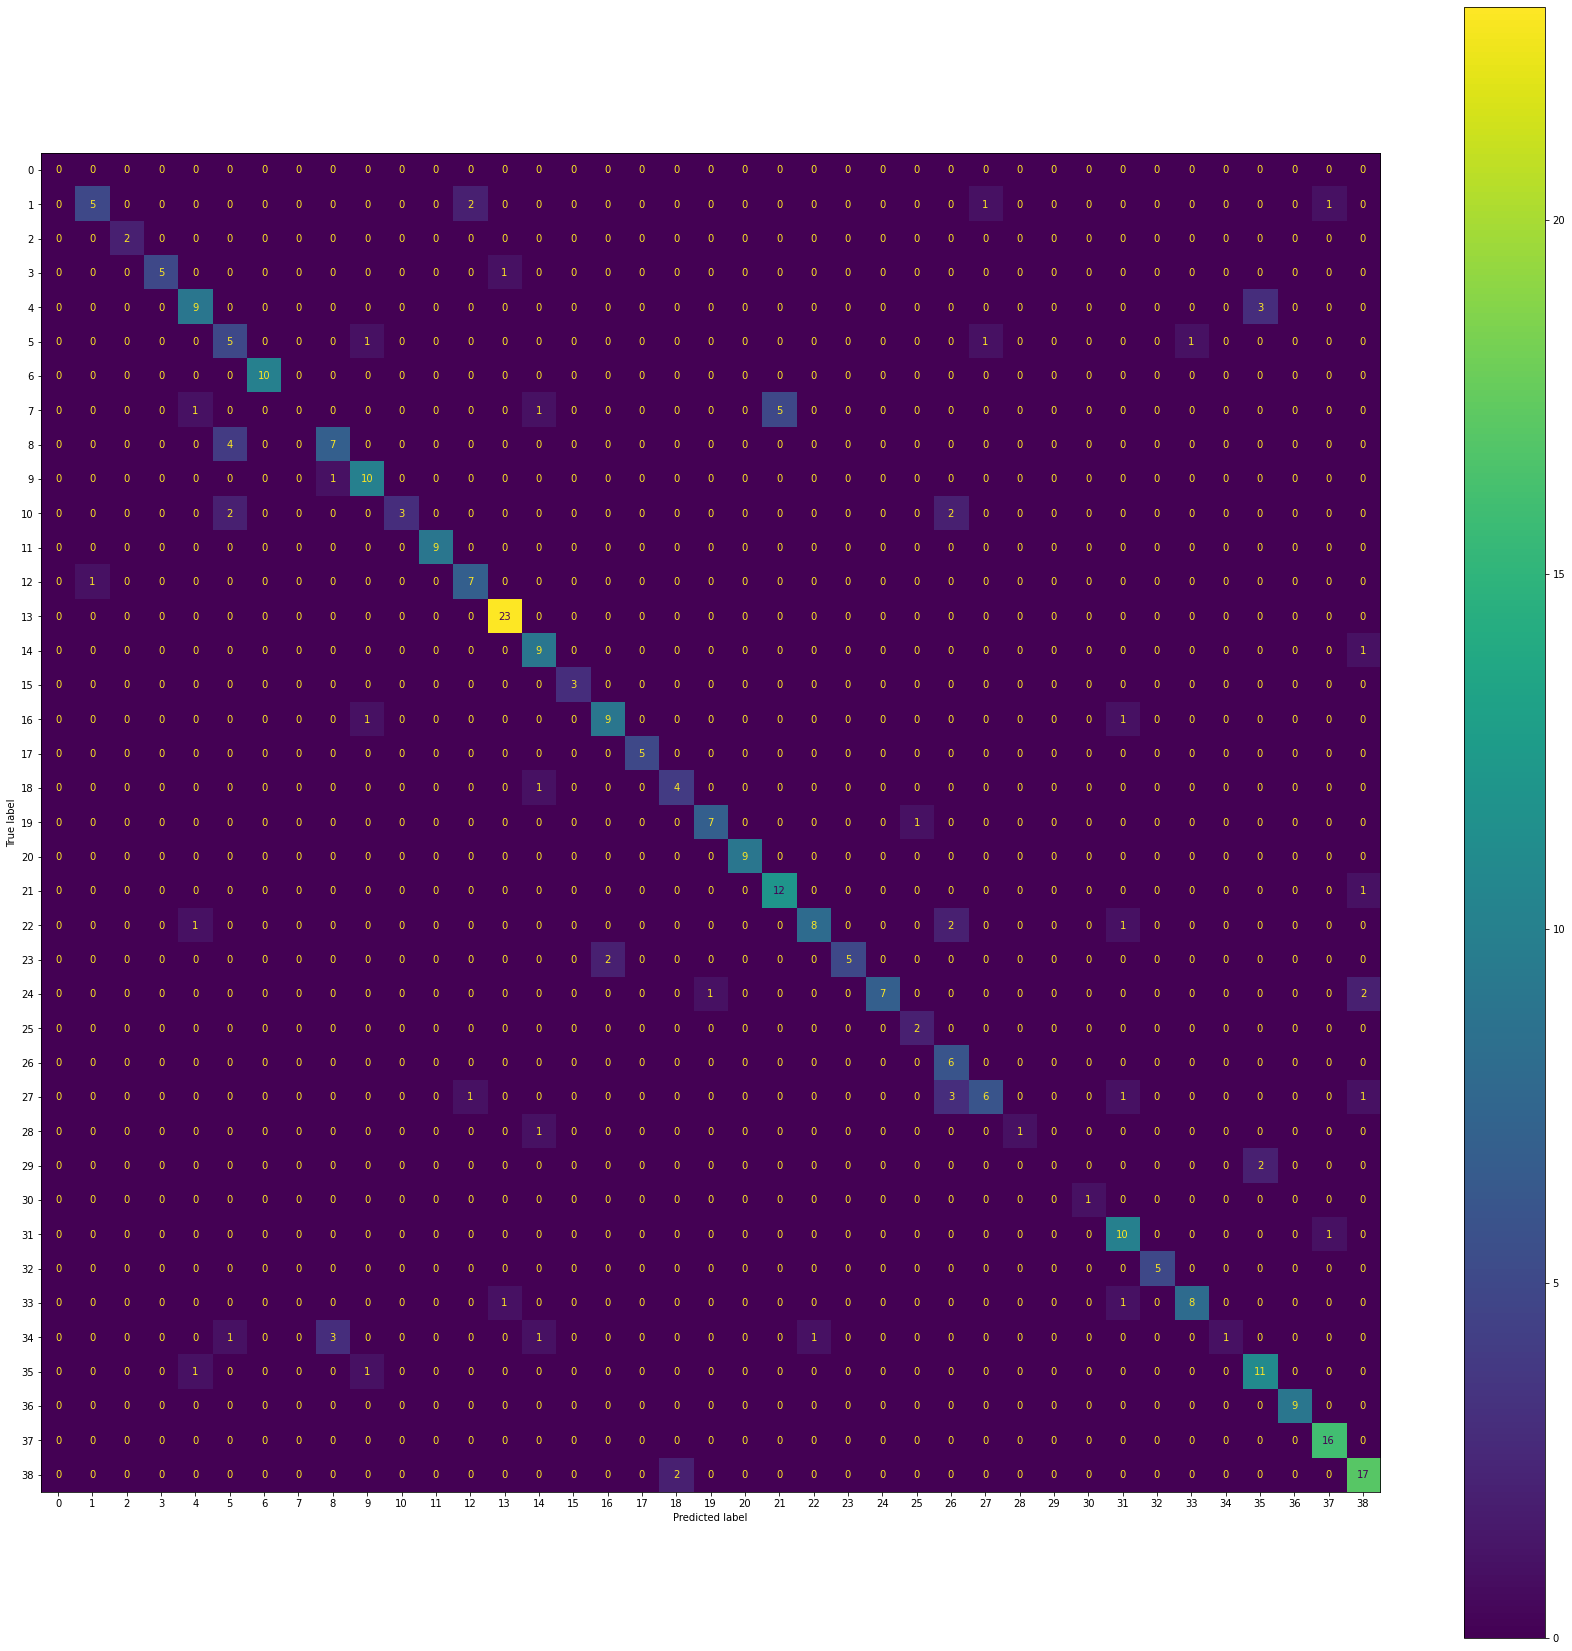

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(30, 30))
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC, y_pred, test_labels, labels=range(0,39), ax=ax);

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, y_pred)

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  6,  0, ...,  0,  0,  0],
       [ 0,  0,  3, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 10,  0,  0],
       [ 0,  0,  0, ...,  0, 11,  0],
       [ 0,  0,  0, ...,  0,  0, 16]])